In [1]:
# default_exp vector_zonal_stats

In [2]:
# hide
# no_test
! [ -e /content ] && pip install -Uqq git+https://github.com/thinkingmachines/geowrangler.git
! [ -e /content ] && pip install -Uqq git+https://github.com/butchland/nbdev.git@add-black-format
# downgrade tornado if in colab
! [ -e /content ] && pip install -Uqq tornado==5.1.0

In [3]:
# hide
# no_test
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
# hide
# no_test
# conditionally load nb_black cell magic
import sys

IN_COLAB = True
if "google.colab" not in sys.modules:
    from IPython import get_ipython

    IN_COLAB = False
    ipython = get_ipython()
    ipython.magic("reload_ext lab_black")

In [5]:
# hide
import warnings

from shapely.errors import ShapelyDeprecationWarning

warnings.filterwarnings(action="ignore", category=UserWarning, module="geopandas")
warnings.filterwarnings(
    action="ignore", category=ShapelyDeprecationWarning, module="pandas"
)

# Vector Zonal Stats

> generate vector zonal stat features

In [6]:
# hide
import matplotlib.pyplot as plt
from nbdev.export2html import show_doc
from shapely.geometry import Point, Polygon

In [7]:
# exporti
GEO_INDEX_NAME = "__GeoWrangleer_aoi_index"

In [8]:
# exporti
from typing import Any, Dict, List

import geopandas as gpd
import numpy as np
import pandas as pd

### Aggregations

In order to generate zonal stats for an area (or areas) of interest (aoi) , we have come up with the concept of an **aggregation specification** or _agg spec_, which is a way to specify what aggregation functions (such as `count`,`sum`, `mean`,`std` etc.) are to be applied to columns in the source dataframe (data). 

The method `create_zonal_stats` can then take in a list of these _agg specs_ and apply them to create zonal stats from the data for the aoi.

Each _agg spec_ consists of a `dict` with the following keys:

* `func`: (Required) a `str` or a list `[str]` of aggregation functions. See the pandas documentation for [agg](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.agg.html)

* `column`: (Optional) an existing column in the data to generate the zonal statistic from. If not specified, the grouping key based on the index of the aoi applied to the data is used as default.

* `output`: (Optional) a `str` or a list `[str]` of the name(s) of the output zonal statistic column. If not specified it is concatenated from the column and func i.e.  `{column}_{func}` (e.g. `'func':'mean'` on `'column':'population'` has a default value `'output':'population_mean'`) 

* `fillna`: (Optional) a `bool` or a list `[bool]` of the flag(s) that indicates whether to to a `fillna(0)` step for the new zonal column, `True` meaning it will set any `NA` values in the resulting zonal stat to `0`, and `False` will retain any `NA` values. The default value of the flag(s) is `True`.

**Examples**

* The simplest aggregation spec. This will result in an output column named `index_count` as it will use the aoi index as the default column. 
``` 
{"func":"count"}
```

* The `sum` function is applied to the data column `population` which will create an output column named `total_population`.

```
{
 "func:"sum",
 "column": "population",
 "output": "total_population"
}
```

* Compute the zonal stats `mean`,`sum`,`max` on the `population` column and rename the output columns (by default) to `population_mean`, `population_sum` and `population_max`.

```
{
 "func": ["mean","sum","max"],
 "column": "population",
}
 ```

* A full aggregation spec with `fillna`. `fillna == False` for `std` means it will remain an `NA` if there is no data for the column in the group. The default value for `fillna` is `True` which means that `0` is used to replace any `NA` in the output column.
```
{
 "func": ["mean", "sum", "std"],
 "column":"population",
 "output": ["avg_pop", "total_pop", "std_dev"],
 "fillna": [True,True,False],
}
```

The `agg spec` in the list of aggregations can contain the same columns, but the output columns must be unique since they will added as columns in the results.

### Internal API
> These functions are only called internally by the geowrangler module

In [9]:
# export
_all_ = ["_fix_agg"]

In [10]:
# exporti
def _fix_agg(
    agg: Dict[str, Any],  # A dict containing at the minimum a 'func' key
) -> Dict[str, Any]:
    """
    Fix an `agg spec`.

    It outputs a dict containing the following keys:
      - 'func': a list of aggregation functions (should be a valid 'agg' function)
      - 'column': a column to apply the aggregation functions (should be a valid numeric column in data)
      - 'output': the names of the new columns containing the application of the aggregation functions (default: concat column + '_' + func)
      - 'fillna': boolean list whether to replace new columns with 'NA' values  with 0 (default: True)
    """
    if "func" not in agg:
        return agg  # skip fix as agg spec is invalid

    if type(agg["func"]) == str:
        agg["func"] = [agg["func"]]

    # optional column, default to index count
    if "column" not in agg:
        agg["column"] = GEO_INDEX_NAME

    if "output" not in agg:
        column = "index" if agg["column"] == GEO_INDEX_NAME else agg["column"]
        agg["output"] = [f"{column}_{f}" for f in agg["func"]]

    if type(agg["output"]) == str:
        agg["output"] = [agg["output"]]

    # check matching fillna
    if "fillna" not in agg:
        agg["fillna"] = [True for _ in agg["func"]]

    if type(agg["fillna"]) == bool:
        agg["fillna"] = [agg["fillna"]]

    return agg

In [11]:
# hide
assert _fix_agg({"func": ["sum", "max", "min", "mean"], "column": "population"}) == {
    "func": ["sum", "max", "min", "mean"],
    "column": "population",
    "output": ["population_sum", "population_max", "population_min", "population_mean"],
    "fillna": [True, True, True, True],
}

In [12]:
# hide
assert _fix_agg({"func": "count"}) == {
    "func": ["count"],
    "column": GEO_INDEX_NAME,
    "output": ["index_count"],
    "fillna": [True],
}

In [13]:
# hide
assert _fix_agg(
    {
        "func": ["sum", "max", "min", "mean", "std"],
        "column": "population",
        "output": ["pop_sum", "pop_max", "pop_min", "avg_pop", "pop_std_dev"],
        "fillna": [True, True, True, True, False],
    }
) == {
    "func": ["sum", "max", "min", "mean", "std"],
    "column": "population",
    "output": ["pop_sum", "pop_max", "pop_min", "avg_pop", "pop_std_dev"],
    "fillna": [True, True, True, True, False],
}

In [14]:
# hide
assert _fix_agg({"func": "count"}) == {
    "func": ["count"],
    "column": GEO_INDEX_NAME,
    "output": ["index_count"],
    "fillna": [True],
}

In [15]:
show_doc(_fix_agg)

<h4 id="_fix_agg" class="doc_header"><code>_fix_agg</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>_fix_agg</code>(**`agg`**:`Dict`\[`str`, `typing.Any`\])

Fix an `agg spec`.

It outputs a dict containing the following keys:
  - 'func': a list of aggregation functions (should be a valid 'agg' function)
  - 'column': a column to apply the aggregation functions (should be a valid numeric column in data)
  - 'output': the names of the new columns containing the application of the aggregation functions (default: concat column + '_' + func)
  - 'fillna': boolean list whether to replace new columns with 'NA' values  with 0 (default: True)

||Type|Default|Details|
|---|---|---|---|
|**`agg`**|`typing.Dict[str, typing.Any]`||A dict containing at the minimum a 'func' key|


In [16]:
# export
_all_ = ["_check_agg"]

In [17]:
# exporti
def _check_agg(
    agg: Dict[str, Any],  # A dict containing at the minimum a 'func' key
    i: int,  # The index into the list of aggregations
    data_cols: List[str],  # list of data columns
    dtypes: pd.Series,  # series of dtypes with column names as index
) -> None:
    """
    Validate an `agg spec`.
    """

    if "func" not in agg:
        raise ValueError(f"Missing key 'func' in agg[{i}] {agg}")

    for func in agg["func"]:
        if getattr(pd.Series, func, None) is None:
            raise ValueError(f"Unknown func '{func}' in agg[{i}] {agg}")

    if agg["column"] != GEO_INDEX_NAME and agg["column"] not in data_cols:
        raise ValueError(
            f"Column '{agg['column']}' in agg[{i}] {agg} does not exist in the data"
        )

    if agg["column"] != GEO_INDEX_NAME and not np.issubdtype(
        dtypes.loc[agg["column"]], np.number
    ):
        raise ValueError(
            f"Column '{agg['column']}' in agg[{i}] {agg} is not a numeric column in the data"
        )

    if len(agg["func"]) != len(agg["output"]):
        raise ValueError(
            f"output list {agg['output']} doesn't match func list {agg['func']} in agg[{i}] {agg}"
        )

    # check matching fillna
    if len(agg["fillna"]) != len(agg["func"]):
        raise ValueError(
            f"fillna list {agg['fillna']} doesn't match func list {agg['func']} in agg[{i}] {agg}"
        )

In [18]:
# hide
try:
    _check_agg({}, 0, [], pd.Series(dtype=np.float64))
    threw_exception = False
except ValueError as e:
    threw_exception = True
    assert e.args[0] == "Missing key 'func' in agg[0] {}"
assert threw_exception

In [19]:
# hide
try:
    _check_agg(
        {"func": ["mean", "sum"], "column": "population", "output": ["pop_mean"]},
        1,
        ["population"],
        pd.Series(data={"population": np.dtype(np.int32)}),
    )
    threw_exception = False
except ValueError as e:
    threw_exception = True
    assert (
        e.args[0]
        == "output list ['pop_mean'] doesn't match func list ['mean', 'sum'] in agg[1] {'func': ['mean', 'sum'], 'column': 'population', 'output': ['pop_mean']}"
    )
assert threw_exception

In [20]:
show_doc(_check_agg)

<h4 id="_check_agg" class="doc_header"><code>_check_agg</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>_check_agg</code>(**`agg`**:`Dict`\[`str`, `typing.Any`\], **`i`**:`int`, **`data_cols`**:`List`\[`str`\], **`dtypes`**:`Series`)

Validate an `agg spec`.

||Type|Default|Details|
|---|---|---|---|
|**`agg`**|`typing.Dict[str, typing.Any]`||A dict containing at the minimum a 'func' key|
|**`i`**|`int`||The index into the list of aggregations|
|**`data_cols`**|`typing.List[str]`||list of data columns|
|**`dtypes`**|`Series`||series of dtypes with column names as index|


In [21]:
# export
_all_ = ["_validate_aggs"]

In [22]:
# exporti
def _validate_aggs(
    fixed_aggs: List[Dict[str, Any]],  # A list of fixed agg specs
    data: pd.DataFrame,  # Source dataframe
) -> None:
    data_cols = list(data.columns.values)
    outputs = []
    for i, agg in enumerate(fixed_aggs):
        _check_agg(agg, i, data_cols, data.dtypes)
        # check duplicate outputs
        if any(item in agg["output"] for item in outputs):
            raise ValueError(
                f"Duplicate output column name found for agg[{i}] {agg['output']}"
            )
        outputs += agg["output"]

In [23]:
# hide
try:
    _validate_aggs(
        [{"func": ["mean", "sum"], "column": "population", "output": ["pop_mean"]}],
        pd.DataFrame(data={"population": [1, 2, 3]}),
    )
    threw_exception = False
except ValueError as e:
    threw_exception = True
    assert (
        e.args[0]
        == "output list ['pop_mean'] doesn't match func list ['mean', 'sum'] in agg[0] {'func': ['mean', 'sum'], 'column': 'population', 'output': ['pop_mean']}"
    )
assert threw_exception

In [24]:
# hide
try:
    _validate_aggs(
        [
            {
                "func": ["mean", "sum"],
                "column": "population",
                "output": ["pop_mean", "pop_total"],
                "fillna": [True, True],
            }
        ],
        pd.DataFrame(data={"population": [1, 2, 3]}),
    )
    threw_exception = False
except ValueError:
    threw_exception = True
assert not threw_exception

In [25]:
# hide
try:
    _validate_aggs(
        [
            {
                "func": ["mean", "sum"],
                "column": "population",
                "output": ["pop_mean", "pop_total"],
                "fillna": [True, True],
            },
            {
                "func": ["mean", "sum"],
                "column": "dads",
                "output": ["pop_mean", "pop_total"],
                "fillna": [True, True],
            },
        ],
        pd.DataFrame(data={"population": [1, 2, 3], "dads": [5, 6, 7]}),
    )
    threw_exception = False
except ValueError as e:
    threw_exception = True
    assert (
        e.args[0]
        == "Duplicate output column name found for agg[1] ['pop_mean', 'pop_total']"
    )
assert threw_exception

In [26]:
# hide
# TODO - more tests for validating aggs

In [27]:
show_doc(_validate_aggs)

<h4 id="_validate_aggs" class="doc_header"><code>_validate_aggs</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>_validate_aggs</code>(**`fixed_aggs`**:`List`\[`typing.Dict[str, typing.Any]`\], **`data`**:`DataFrame`)



||Type|Default|Details|
|---|---|---|---|
|**`fixed_aggs`**|`typing.List[typing.Dict[str, typing.Any]]`||A list of fixed agg specs|
|**`data`**|`DataFrame`||Source dataframe|


In [28]:
# export
_all_ = ["_expand_aggs"]

In [29]:
# exporti
def _expand_aggs(
    aggs: List[Dict[str, Any]],  # List of fixed valid aggs
) -> List[Dict[str, Any]]:
    """Expands agg specs with multiple funcs each into a separate agg spec"""
    expanded_aggs = []
    for agg in aggs:
        for i, func in enumerate(agg["func"]):
            expanded_agg = {
                "func": func,
                "column": agg["column"],
                "output": agg["output"][i],
                "fillna": agg["fillna"][i],
            }
            expanded_aggs += [expanded_agg]
    return expanded_aggs

In [30]:
# hide
assert _expand_aggs(
    [
        {
            "func": ["mean", "sum"],
            "column": "population",
            "output": ["pop_mean", "pop_total"],
            "fillna": [True, True],
        },
        {
            "func": ["mean", "sum"],
            "column": "dads",
            "output": ["dad_mean", "dad_total"],
            "fillna": [True, True],
        },
    ],
) == [
    {"func": "mean", "column": "population", "output": "pop_mean", "fillna": True},
    {"func": "sum", "column": "population", "output": "pop_total", "fillna": True},
    {"func": "mean", "column": "dads", "output": "dad_mean", "fillna": True},
    {"func": "sum", "column": "dads", "output": "dad_total", "fillna": True},
]

In [31]:
show_doc(_expand_aggs)

<h4 id="_expand_aggs" class="doc_header"><code>_expand_aggs</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>_expand_aggs</code>(**`aggs`**:`List`\[`typing.Dict[str, typing.Any]`\])

Expands agg specs with multiple funcs each into a separate agg spec

||Type|Default|Details|
|---|---|---|---|
|**`aggs`**|`typing.List[typing.Dict[str, typing.Any]]`||List of fixed valid aggs|


In [32]:
# export
_all_ = ["_build_agg_args"]

In [33]:
# exporti
def _build_agg_args(
    aggs: List[Dict[str, Any]],  # A list of expanded aggs
) -> Dict:
    """Builds a dict of args with output as key and a tuple of column and func as value from a list of expanded aggs"""
    return {agg["output"]: (agg["column"], agg["func"]) for agg in aggs}

In [34]:
# hide

assert _build_agg_args(
    [
        {"func": "mean", "column": "population", "output": "pop_mean", "fillna": True},
        {"func": "sum", "column": "population", "output": "pop_total", "fillna": True},
        {"func": "mean", "column": "dads", "output": "dad_mean", "fillna": True},
        {"func": "sum", "column": "dads", "output": "dad_total", "fillna": True},
    ]
) == {
    "pop_mean": ("population", "mean"),
    "pop_total": ("population", "sum"),
    "dad_mean": ("dads", "mean"),
    "dad_total": ("dads", "sum"),
}

In [35]:
show_doc(_build_agg_args)

<h4 id="_build_agg_args" class="doc_header"><code>_build_agg_args</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>_build_agg_args</code>(**`aggs`**:`List`\[`typing.Dict[str, typing.Any]`\])

Builds a dict of args with output as key and a tuple of column and func as value from a list of expanded aggs

||Type|Default|Details|
|---|---|---|---|
|**`aggs`**|`typing.List[typing.Dict[str, typing.Any]]`||A list of expanded aggs|


In [36]:
# export
_all_ = ["_prep_aoi"]

In [37]:
# exporti


def _prep_aoi(
    aoi: pd.DataFrame,  # Area of interest
) -> pd.DataFrame:
    """
    Prepare aoi for spatial join
      - split off any existing column named index and drop it from aoi
      - create a column  from aoi's index which will be used as grouping key
    """
    if GEO_INDEX_NAME in list(aoi.columns.values):
        raise ValueError(
            f"Invalid column name error: AOI column should not match Geowrangler index column {GEO_INDEX_NAME}"
        )
    # prep for spatial join
    aoi = aoi.copy()

    # handle existing col named 'index'
    aoi_index_data = None
    if "index" in list(aoi.columns.values):
        aoi_index_data = aoi["index"]
        aoi.drop(labels="index", inplace=True, axis=1)

    # create index col for broadcast to features
    aoi.reset_index(level=0, inplace=True)
    aoi.rename(columns={"index": GEO_INDEX_NAME}, inplace=True)
    return aoi, aoi_index_data

In [38]:
# hide
test_aoi = pd.DataFrame(data={"col1": [1, 2, 3]})
result, index_data = _prep_aoi(test_aoi)
assert index_data is None
assert any(
    colname in list(result.columns.values)
    for colname in [*list(test_aoi.columns.values), GEO_INDEX_NAME]
)

In [39]:
# hide
test_aoi = pd.DataFrame(data={"col1": [1, 2, 3], "index": [5, 6, 7]})
result, index_data = _prep_aoi(test_aoi)
assert any(
    colname in list(result.columns.values)
    for colname in [*list(test_aoi.columns.values), GEO_INDEX_NAME]
)
assert index_data.equals(pd.Series([5, 6, 7], name="index"))

In [40]:
show_doc(_prep_aoi)

<h4 id="_prep_aoi" class="doc_header"><code>_prep_aoi</code><a href="__main__.py#L4" class="source_link" style="float:right">[source]</a></h4>

> <code>_prep_aoi</code>(**`aoi`**:`DataFrame`)

Prepare aoi for spatial join
  - split off any existing column named index and drop it from aoi
  - create a column  from aoi's index which will be used as grouping key

||Type|Default|Details|
|---|---|---|---|
|**`aoi`**|`DataFrame`||Area of interest|


In [41]:
# hide
# TODO - add tests
# - show addition of aoi_index
# - show split if existing column index
# - show split if existing column aoi_index

In [42]:
# export
_all_ = ["_fillnas"]

In [43]:
# exporti


def _fillnas(
    expanded_aggs: List[Dict[str, Any]],  # list of expanded aggs
    results: pd.DataFrame,  # results dataframe to be filled with NAs if flag set
    aoi: pd.DataFrame,  # aoi dataframe to merge it back to
):
    # set NAs to 0 if fillna
    for agg in expanded_aggs:
        if agg["fillna"]:
            colname = agg["output"]
            if colname in list(aoi.columns.values):
                colname = colname + "_y"  # try if merged df has colname + _y
            if colname in list(results.columns.values):
                results[colname].fillna(0, inplace=True)

In [44]:
show_doc(_fillnas)

<h4 id="_fillnas" class="doc_header"><code>_fillnas</code><a href="__main__.py#L4" class="source_link" style="float:right">[source]</a></h4>

> <code>_fillnas</code>(**`expanded_aggs`**:`List`\[`typing.Dict[str, typing.Any]`\], **`results`**:`DataFrame`, **`aoi`**:`DataFrame`)



||Type|Default|Details|
|---|---|---|---|
|**`expanded_aggs`**|`typing.List[typing.Dict[str, typing.Any]]`||list of expanded aggs|
|**`results`**|`DataFrame`||results dataframe to be filled with NAs if flag set|
|**`aoi`**|`DataFrame`||aoi dataframe to merge it back to|


In [45]:
# hide
results = pd.DataFrame(data={"pop_total": [pd.NA, pd.NA, 5]})
aoi = pd.DataFrame(data={"col1": [1, 2, 3]})
_fillnas([{"output": "pop_total", "fillna": True}], results, aoi)
assert results.equals(pd.DataFrame(data={"pop_total": [0, 0, 5]}))

In [46]:
# hide
results = pd.DataFrame(data={"pop_total": [pd.NA, pd.NA, 5]})
aoi = pd.DataFrame(data={"col1": [1, 2, 3]})
_fillnas([{"output": "pop_total", "fillna": False}], results, aoi)
assert results.equals(pd.DataFrame(data={"pop_total": [pd.NA, pd.NA, 5]}))

In [47]:
# hide
results = pd.DataFrame(data={"pop_total_y": [pd.NA, pd.NA, 5]})
aoi = pd.DataFrame(data={"pop_total": [1, 2, 3]})
_fillnas([{"output": "pop_total", "fillna": True}], results, aoi)
assert results.equals(pd.DataFrame(data={"pop_total_y": [0, 0, 5]}))

In [48]:
# export
_all_ = ["_aggregate_stats"]

In [49]:
# exporti


def _aggregate_stats(
    aoi: pd.DataFrame,  # Area of interest
    groups: pd.core.groupby.DataFrameGroupBy,  # Source data aggregated into groups by GEO_INDEX_NAME
    expanded_aggs: List[Dict[str, Any]],  # A list of expanded aggs
) -> pd.DataFrame:
    """Aggregate groups and compute the agg['func'] for agg['column'], map them to the output column in agg['column'] for all the aggs in the expanded_aggs list
    and merge them back to aoi dataframe
    """
    agg_dicts = _build_agg_args(expanded_aggs)
    aggregates = groups.agg(**agg_dicts)
    results = aoi.merge(
        aggregates, how="left", on=GEO_INDEX_NAME, suffixes=(None, "_y")
    )
    _fillnas(expanded_aggs, results, aoi)

    return results

In [50]:
show_doc(_aggregate_stats)

<h4 id="_aggregate_stats" class="doc_header"><code>_aggregate_stats</code><a href="__main__.py#L4" class="source_link" style="float:right">[source]</a></h4>

> <code>_aggregate_stats</code>(**`aoi`**:`DataFrame`, **`groups`**:`DataFrameGroupBy`, **`expanded_aggs`**:`List`\[`typing.Dict[str, typing.Any]`\])

Aggregate groups and compute the agg['func'] for agg['column'], map them to the output column in agg['column'] for all the aggs in the expanded_aggs list
and merge them back to aoi dataframe

||Type|Default|Details|
|---|---|---|---|
|**`aoi`**|`DataFrame`||Area of interest|
|**`groups`**|`DataFrameGroupBy`||Source data aggregated into groups by GEO_INDEX_NAME|
|**`expanded_aggs`**|`typing.List[typing.Dict[str, typing.Any]]`||A list of expanded aggs|


In [51]:
# hide
expanded_aggs = [
    {"func": "mean", "column": "population", "output": "pop_mean", "fillna": True},
    {"func": "sum", "column": "population", "output": "pop_total", "fillna": True},
    {"func": "mean", "column": "dads", "output": "dad_mean", "fillna": True},
    {"func": "sum", "column": "dads", "output": "dad_total", "fillna": True},
]
aoi = pd.DataFrame(
    data={
        GEO_INDEX_NAME: [
            1,
            2,
            3,
        ],
        "col1": ["a", "b", "c"],
    }
)
features = pd.DataFrame(
    data={
        GEO_INDEX_NAME: [1, 1, 1, 2, 2, 2, 3, 3, 3],
        "population": [1, 2, 3, 4, 5, 6, 7, 8, 9],
        "dads": [10, 20, 30, 40, 50, 60, pd.NA, pd.NA, pd.NA],
    }
)
groups = features.groupby(GEO_INDEX_NAME)

In [52]:
# hide
assert _aggregate_stats(aoi, groups, expanded_aggs).equals(
    pd.DataFrame(
        data={
            GEO_INDEX_NAME: [1, 2, 3],
            "col1": ["a", "b", "c"],
            "pop_mean": [2.0, 5.0, 8.0],
            "pop_total": [6, 15, 24],
            "dad_mean": [20.0, 50.0, 0.0],
            "dad_total": [60, 150, 0],
        }
    )
)

In [53]:
# hide
# TODO:
# - setup aggregate stats inputs
# - show examples of aggregate stats

### External API

In [54]:
# export


def create_zonal_stats(
    aoi: gpd.GeoDataFrame,  # Area of interest for which zonal stats are to be computed for
    data: gpd.GeoDataFrame,  # Source gdf containing data to compute zonal stats from
    aggregations: List[  # List of agg specs, with each agg spec applied to a data column
        Dict[str, Any]
    ],
    overlap_method: str = "intersects",  # spatial predicate to used in spatial join of aoi and data [geopandas.sjoin](https://geopandas.org/en/stable/docs/user_guide/mergingdata.html#binary-predicate-joins) for more details
    # categorical_column_options: str = None,
) -> gpd.GeoDataFrame:
    """
    Create zonal stats for area of interest from data using aggregration operations on data columns.
    Returns the same aoi with additional columns containing the computed zonal features.
    """

    fixed_aggs = [_fix_agg(agg) for agg in aggregations]

    _validate_aggs(fixed_aggs, data)

    # prep for spatial join
    aoi, aoi_index_data = _prep_aoi(aoi)

    if not data.crs.equals(aoi.crs):
        data = data.to_crs(aoi.crs)

    # spatial join - broadcast aoi_index to data => features
    features = gpd.sjoin(
        aoi[[GEO_INDEX_NAME, "geometry"]], data, how="inner", predicate=overlap_method
    )

    # group
    groups = features.groupby(GEO_INDEX_NAME)

    # apply all aggregations all at once
    expanded_aggs = _expand_aggs(fixed_aggs)
    results = _aggregate_stats(aoi, groups, expanded_aggs)

    # cleanup results
    results.drop(labels=GEO_INDEX_NAME, inplace=True, axis=1)
    if aoi_index_data is not None:
        results["index"] = aoi_index_data

    return results

In [55]:
show_doc(create_zonal_stats)

<h4 id="create_zonal_stats" class="doc_header"><code>create_zonal_stats</code><a href="__main__.py#L4" class="source_link" style="float:right">[source]</a></h4>

> <code>create_zonal_stats</code>(**`aoi`**:`GeoDataFrame`, **`data`**:`GeoDataFrame`, **`aggregations`**:`List`\[`typing.Dict[str, typing.Any]`\], **`overlap_method`**:`str`=*`'intersects'`*)

Create zonal stats for area of interest from data using aggregration operations on data columns.
Returns the same aoi with additional columns containing the computed zonal features.

||Type|Default|Details|
|---|---|---|---|
|**`aoi`**|`GeoDataFrame`||Area of interest for which zonal stats are to be computed for|
|**`data`**|`GeoDataFrame`||Source gdf containing data to compute zonal stats from|
|**`aggregations`**|`typing.List[typing.Dict[str, typing.Any]]`||List of agg specs, with each agg spec applied to a data column|
|**`overlap_method`**|`str`|`intersects`|spatial predicate to used in spatial join of aoi and data [geopandas.sjoin](https://geopandas.org/en/stable/docs/user_guide/mergingdata.html#binary-predicate-joins) for more details|


In [56]:
# hide
# setup for create_zonal_stats test
# see tests/test_vector_zonal_stats.py
def make_simple_aoi():
    df = pd.DataFrame(
        data={
            "col1": [1, 2, 3],
            "lat0": [0.0, 1.0, 2.0],
            "lon0": [0.0, 0.0, 0.0],
            "lat1": [0.0, 1.0, 2.0],
            "lon1": [1.0, 1.0, 1.0],
            "lat2": [1.0, 2.0, 3.0],
            "lon2": [1.0, 1.0, 1.0],
            "lat3": [1.0, 2.0, 3.0],
            "lon3": [0.0, 0.0, 0.0],
        }
    )

    def square(row):
        return Polygon(
            (
                [
                    (row.lat0, row.lon0),
                    (row.lat1, row.lon1),
                    (row.lat2, row.lon2),
                    (row.lat3, row.lon3),
                ]
            )
        )

    return gpd.GeoDataFrame(df, geometry=df.apply(square, axis=1), crs="EPSG:4326")


def make_simple_data():
    df = pd.DataFrame(
        data={
            "col1": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
            "lat": [
                0.5,
                1.5,
                2.5,
                0.45,
                1.45,
                2.45,
                0.45,
                1.45,
                2.45,
                0.45,
                1.45,
                2.45,
            ],
            "lon": [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.45, 0.45, 0.45, 1.45, 1.45, 1.45],
        }
    )
    return gpd.GeoDataFrame(
        df,
        geometry=df.apply(lambda row: Point(row.lat, row.lon), axis=1),
        crs="EPSG:4326",
    )


simple_aoi = make_simple_aoi()
simple_data = make_simple_data()

In [57]:
simple_aoi  # sample aoi

,col1,lat0,lon0,lat1,lon1,lat2,lon2,lat3,lon3,geometry
0,1,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,"POLYGON ((0.00000 0.00000, 0.00000 1.00000, 1...."
1,2,1.0,0.0,1.0,1.0,2.0,1.0,2.0,0.0,"POLYGON ((1.00000 0.00000, 1.00000 1.00000, 2...."
2,3,2.0,0.0,2.0,1.0,3.0,1.0,3.0,0.0,"POLYGON ((2.00000 0.00000, 2.00000 1.00000, 3...."


In [58]:
simple_data  # sample data

,col1,lat,lon,geometry
0,1,0.50,0.50,POINT (0.50000 0.50000)
1,2,1.50,0.50,POINT (1.50000 0.50000)
2,3,2.50,0.50,POINT (2.50000 0.50000)
3,4,0.45,0.50,POINT (0.45000 0.50000)
4,5,1.45,0.50,POINT (1.45000 0.50000)
5,6,2.45,0.50,POINT (2.45000 0.50000)
6,7,0.45,0.45,POINT (0.45000 0.45000)
7,8,1.45,0.45,POINT (1.45000 0.45000)
8,9,2.45,0.45,POINT (2.45000 0.45000)
9,10,0.45,1.45,POINT (0.45000 1.45000)


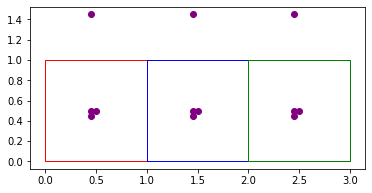

In [59]:
ax = simple_aoi.plot(
    ax=plt.axes(), facecolor="none", edgecolor=["red", "blue", "green"]
)
ax = simple_data.plot(ax=ax, color="purple")

In [60]:
results = create_zonal_stats(simple_aoi, simple_data, aggregations=[{"func": "count"}])
results

,col1,lat0,lon0,lat1,lon1,lat2,lon2,lat3,lon3,geometry,index_count
0,1,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,"POLYGON ((0.00000 0.00000, 0.00000 1.00000, 1....",3
1,2,1.0,0.0,1.0,1.0,2.0,1.0,2.0,0.0,"POLYGON ((1.00000 0.00000, 1.00000 1.00000, 2....",3
2,3,2.0,0.0,2.0,1.0,3.0,1.0,3.0,0.0,"POLYGON ((2.00000 0.00000, 2.00000 1.00000, 3....",3


In [61]:
# hide
assert any(
    item in list(results.columns.values)
    for item in [*list(simple_aoi.columns.values), "index_count"]
)
assert results.index_count.sum() == 9
assert results.iloc[0].index_count == 3

In [62]:
# hide
# no_test
from nbdev.export import notebook2script

if not IN_COLAB:
    notebook2script("02_vector_zonal_stats.ipynb")

Converted 02_vector_zonal_stats.ipynb.
